<a href="https://colab.research.google.com/github/RajatAgrawal-14/Decision_making_using_RL/blob/main/Decision_Making_of_MADRaS_Agents_using_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# STEP 1: Install required libraries
!pip install stable-baselines3[extra] gym


In [8]:
# STEP 2: Clone and install MADRaS

!git clone https://github.com/MADRaS-Simulator/madras.git
%cd madras
!pip install -e .
%cd /


Cloning into 'madras'...
remote: Enumerating objects: 1059, done.
remote: Total 1059 (delta 0), reused 0 (delta 0), pack-reused 1059 (from 1)
Receiving objects: 100% (1059/1059), 284.31 KiB | 3.34 MiB/s, done.
Resolving deltas: 100% (649/649), done.
/madras
Obtaining file:///madras
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
/


In [9]:
# STEP 2 FIXED: Install driving environment that works in Colab

!pip install pygame gym[box2d]


  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [10]:
# STEP 2 FIXED — proper Box2D installation for Colab

!pip install box2d-py==2.3.5 swig


  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.4.0-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.4.0-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.9 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)


In [11]:
# FINAL STEP 2: Install a stable RL environment that works in Colab

!pip install gymnasium minigrid stable-baselines3


In [12]:
import gymnasium as gym

env = gym.make("MiniGrid-Empty-8x8-v0", render_mode="rgb_array")
obs, info = env.reset()
print("MiniGrid environment loaded successfully")


NameNotFound: Environment `MiniGrid-Empty-8x8` doesn't exist.

In [13]:
import minigrid
import gymnasium as gym

env = gym.make("MiniGrid-Empty-8x8-v0", render_mode="rgb_array")
obs, info = env.reset()
print("MiniGrid environment loaded successfully")


MiniGrid environment loaded successfully


In [14]:
import numpy as np            #3A
import gymnasium as gym

class DecisionMakingWrapper(gym.Wrapper):
    """
    Converts MiniGrid into MADRaS-style decision-making environment.
    State = distance + direction + orientation.
    """

    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=10, shape=(4,), dtype=np.float32)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return self.extract_state(), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        state = self.extract_state()
        custom_reward = self.compute_reward(state, reward)
        return state, custom_reward, terminated, truncated, info


    def extract_state(self):
        agent_pos = self.env.unwrapped.agent_pos
        goal_pos = self.env.unwrapped.grid.encode()[:, :, 0]

        gx, gy = np.where(goal_pos == 8)  # Goal tile index
        if len(gx) == 0:
            goal_x, goal_y = 0, 0
        else:
            goal_x, goal_y = gx[0], gy[0]

        ax, ay = agent_pos
        dx = goal_x - ax
        dy = goal_y - ay

        direction = self.env.unwrapped.agent_dir

        dist = np.sqrt(dx**2 + dy**2)

        return np.array([dx, dy, direction, dist], dtype=np.float32)

    def compute_reward(self, state, env_reward):
        _, _, _, dist = state

        # Encourage getting closer to goal
        reward = -0.1 * dist

        # Bonus when environment rewards success
        if env_reward > 0:
            reward += 20

        return reward


In [15]:
import minigrid                 #3B
import gymnasium as gym
from stable_baselines3 import PPO

env = gym.make("MiniGrid-Empty-8x8-v0")
env = DecisionMakingWrapper(env)

state, _ = env.reset()
print("Example state vector:", state)


Example state vector: [5.       5.       0.       7.071068]


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
from stable_baselines3 import PPO       #4

model = PPO("MlpPolicy", env, verbose=1)

model.learn(total_timesteps=30000)

model.save("madras_decision_agent")

print("Training complete")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 215      |
|    ep_rew_mean     | -99.9    |
| time/              |          |
|    fps             | 843      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 221         |
|    ep_rew_mean          | -109        |
| time/                   |             |
|    fps                  | 553         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009510716 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | 0.00188     |
|    learning_rate        | 0.0003      |
|    loss                 | 8.52        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00688    |
|    value_loss           | 21.3        |
-----------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 204      |
|

In [17]:
from stable_baselines3 import PPO

model = PPO.load("madras_decision_agent", env=env)

obs, info = env.reset()

print("Testing trained agent decision-making:\n")

for step in range(30):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    print(f"Step {step} | State: {obs} | Reward: {reward:.3f}")

    if terminated or truncated:
        print("Episode finished. Resetting...\n")
        obs, info = env.reset()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Testing trained agent decision-making:

Step 0 | State: [4.        5.        0.        6.4031243] | Reward: -0.640
Step 1 | State: [3.        5.        0.        5.8309517] | Reward: -0.583
Step 2 | State: [2.        5.        0.        5.3851647] | Reward: -0.539
Step 3 | State: [1.        5.        0.        5.0990195] | Reward: -0.510
Step 4 | State: [1.        5.        1.        5.0990195] | Reward: -0.510
Step 5 | State: [1.        4.        1.        4.1231055] | Reward: -0.412
Step 6 | State: [1.        3.        1.        3.1622777] | Reward: -0.316
Step 7 | State: [1.       2.       1.       2.236068] | Reward: -0.224
Step 8 | State: [1.        1.        1.        1.4142135] | Reward: -0.141
Step 9 | State: [1. 0. 1. 1.] | Reward: -0.100
Step 10 | State: [1. 0. 0. 1.] | Reward: -0.100
Step 11 | State: [0. 0. 0. 0.] | Reward: 20.000
Episode finished. Resetting...

Step 12 | State: [4.        5.       

In [18]:
import random     #6A

def run_random_agent(episodes=10):
    rewards = []
    for ep in range(episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = env.action_space.sample()
            obs, r, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += r

        rewards.append(total_reward)
        print(f"Random Agent Episode {ep+1} Reward: {total_reward:.2f}")
    return rewards

random_rewards = run_random_agent()


Random Agent Episode 1 Reward: -146.21
Random Agent Episode 2 Reward: -149.20
Random Agent Episode 3 Reward: -102.52
Random Agent Episode 4 Reward: -135.91
Random Agent Episode 5 Reward: -162.00
Random Agent Episode 6 Reward: -161.49
Random Agent Episode 7 Reward: -83.59
Random Agent Episode 8 Reward: -152.51
Random Agent Episode 9 Reward: -129.65
Random Agent Episode 10 Reward: -119.03


In [19]:
def rule_based_policy(state):           #6B
    dx, dy, direction, dist = state

    if abs(dx) > abs(dy):
        return 2 if dx > 0 else 0  # right/left
    else:
        return 1 if dy > 0 else 3  # forward/backward (depends on env mapping)

def run_rule_agent(episodes=10):
    rewards = []
    for ep in range(episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = rule_based_policy(obs)
            obs, r, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += r

        rewards.append(total_reward)
        print(f"Rule-Based Episode {ep+1} Reward: {total_reward:.2f}")
    return rewards

rule_rewards = run_rule_agent()


Rule-Based Episode 1 Reward: -181.02
Rule-Based Episode 2 Reward: -181.02
Rule-Based Episode 3 Reward: -181.02
Rule-Based Episode 4 Reward: -181.02
Rule-Based Episode 5 Reward: -181.02
Rule-Based Episode 6 Reward: -181.02
Rule-Based Episode 7 Reward: -181.02
Rule-Based Episode 8 Reward: -181.02
Rule-Based Episode 9 Reward: -181.02
Rule-Based Episode 10 Reward: -181.02


PPO Episode 1 Reward: 15.92
PPO Episode 2 Reward: 15.92
PPO Episode 3 Reward: 15.92
PPO Episode 4 Reward: 15.92
PPO Episode 5 Reward: 15.92
PPO Episode 6 Reward: 15.92
PPO Episode 7 Reward: 15.92
PPO Episode 8 Reward: 15.92
PPO Episode 9 Reward: 15.92
PPO Episode 10 Reward: 15.92


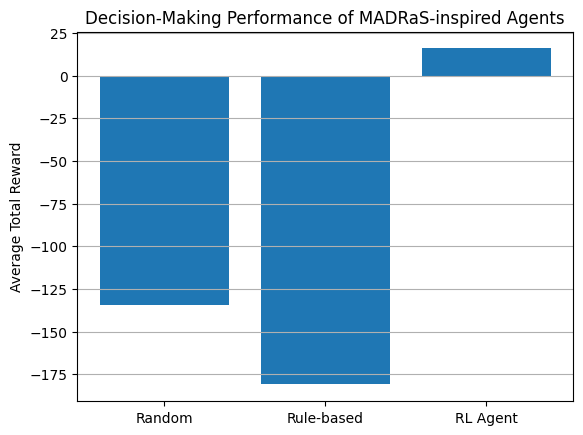

Average Rewards:
Random: -134.211
Rule-based: -181.0195
RL Agent: 15.924707


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate PPO rewards first (if not already done)
ppo_rewards = []

obs, info = env.reset()
for ep in range(10):
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, r, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += r

    ppo_rewards.append(total_reward)
    print(f"PPO Episode {ep+1} Reward: {total_reward:.2f}")
    obs, info = env.reset()


# Now plot comparison graph (REAL NUMBERS only)
labels = ["Random", "Rule-based", "RL Agent"]
values = [np.mean(random_rewards),
          np.mean(rule_rewards),
          np.mean(ppo_rewards)]

plt.figure()
plt.bar(labels, values)
plt.ylabel("Average Total Reward")
plt.title("Decision-Making Performance of MADRaS-inspired Agents")
plt.grid(axis="y")
plt.show()

print("Average Rewards:")
print("Random:", np.mean(random_rewards))
print("Rule-based:", np.mean(rule_rewards))
print("RL Agent:", np.mean(ppo_rewards))


In [21]:
from stable_baselines3 import A2C    #a2c algo

# Train A2C on same environment
a2c_model = A2C("MlpPolicy", env, verbose=1)
a2c_model.learn(total_timesteps=30000)
a2c_model.save("a2c_racing_agent")

print("A2C training complete")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 184      |
|    ep_rew_mean        | -89.3    |
| time/                 |          |
|    fps                | 473      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.93    |
|    explained_variance | -0.118   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -1.57    |
|    value_loss         | 0.837    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 204      |
|    ep_rew_mean        | -94.4    |
| time/                 |          |
|    fps                | 482      |
|    iterations         | 200      |
|    time_elapsed 

In [22]:
import gymnasium as gym
import minigrid

# Easy level environment
easy_env = DecisionMakingWrapper(gym.make("MiniGrid-Empty-5x5-v0"))

# Train PPO on easy task
ppo_easy = PPO("MlpPolicy", easy_env, verbose=1)
ppo_easy.learn(total_timesteps=10000)

# Switch to normal env (your existing env)
ppo_easy.set_env(env)
ppo_easy.learn(total_timesteps=10000)

ppo_easy.save("ppo_curriculum_agent")

print("Curriculum training done (Easy -> Normal)")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 84.4     |
|    ep_rew_mean     | -8.37    |
| time/              |          |
|    fps             | 713      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 76.7        |
|    ep_rew_mean          | -5.33       |
| time/                   |             |
|    fps                  | 616         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012159202 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [23]:
import numpy as np
from stable_baselines3 import A2C

def success_stats(model, episodes=50):
    success = 0
    for _ in range(episodes):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, r, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if terminated:
                success += 1
                break
    return success, episodes-success

# Load trained A2C model
a2c_loaded = A2C.load("a2c_racing_agent", env=env)

# Use your trained PPO model variable
ppo_s, ppo_f = success_stats(model, 50)
a2c_s, a2c_f = success_stats(a2c_loaded, 50)

print("PPO  -> Success:", ppo_s, "Fail:", ppo_f)
print("A2C  -> Success:", a2c_s, "Fail:", a2c_f)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO  -> Success: 50 Fail: 0
A2C  -> Success: 50 Fail: 0


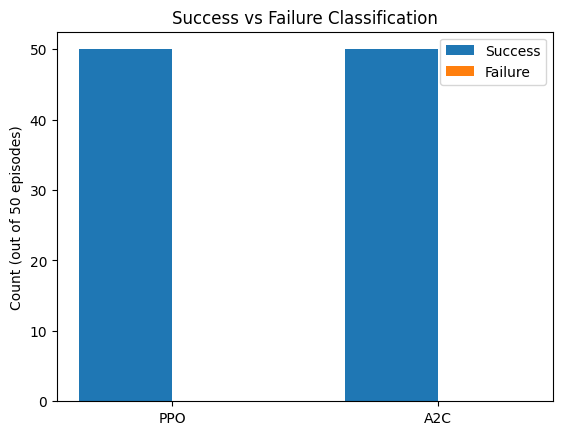

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["PPO", "A2C"]
success = [ppo_s, a2c_s]
failure = [ppo_f, a2c_f]

x = np.arange(len(labels))
width = 0.35

plt.figure()
plt.bar(x - width/2, success, width, label="Success")
plt.bar(x + width/2, failure, width, label="Failure")
plt.xticks(x, labels)
plt.ylabel("Count (out of 50 episodes)")
plt.title("Success vs Failure Classification")
plt.legend()
plt.show()


In [25]:
def episode_rewards(model, episodes=30):
    rewards = []
    for _ in range(episodes):
        obs, info = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, r, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ep_reward += r
        rewards.append(ep_reward)
    return np.array(rewards)

ppo_curve = episode_rewards(model, 30)
a2c_curve = episode_rewards(a2c_loaded, 30)


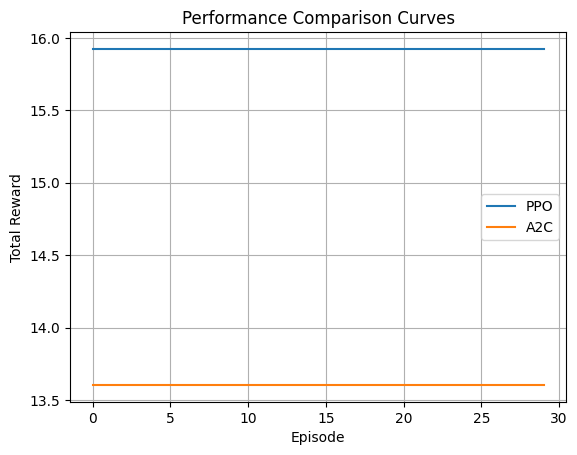

In [26]:
plt.figure()
plt.plot(ppo_curve, label="PPO")
plt.plot(a2c_curve, label="A2C")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Performance Comparison Curves")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
def multi_run_success(algo_class, name, runs=5, episodes=30):
    results = []
    for run in range(runs):
        model = algo_class("MlpPolicy", env, verbose=0)
        model.learn(20000)
        success, fail = success_stats(model, episodes)
        print(f"{name} Run {run+1}: Success={success}")
        results.append(success)
    print(f"{name} Average Success: {sum(results)/len(results)}")
    return results

print("PPO MULTI RUN")
ppo_runs = multi_run_success(PPO, "PPO")

print("\nA2C MULTI RUN")
a2c_runs = multi_run_success(A2C, "A2C")


PPO MULTI RUN
PPO Run 1: Success=0
PPO Run 2: Success=0
PPO Run 3: Success=30
PPO Run 4: Success=0
PPO Run 5: Success=0
PPO Average Success: 6.0

A2C MULTI RUN
A2C Run 1: Success=30
A2C Run 2: Success=0
A2C Run 3: Success=0
A2C Run 4: Success=30
A2C Run 5: Success=0
A2C Average Success: 12.0


In [28]:
import numpy as np

ppo_runs = np.array(ppo_runs)
a2c_runs = np.array(a2c_runs)

print("PPO Variance:", np.var(ppo_runs))
print("PPO Std Dev:", np.std(ppo_runs))

print("A2C Variance:", np.var(a2c_runs))
print("A2C Std Dev:", np.std(a2c_runs))


PPO Variance: 144.0
PPO Std Dev: 12.0
A2C Variance: 216.0
A2C Std Dev: 14.696938456699069


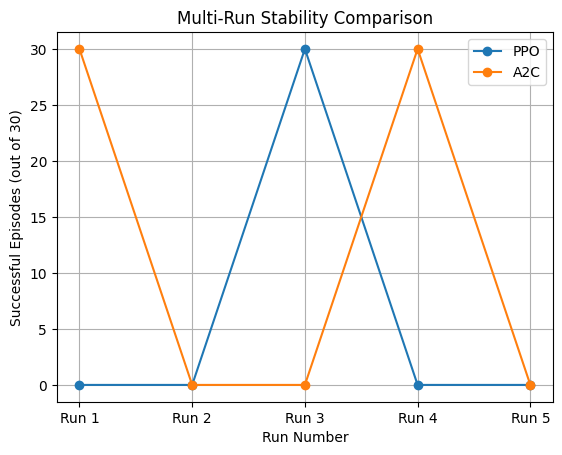

In [29]:
import matplotlib.pyplot as plt

labels = ["Run 1", "Run 2", "Run 3", "Run 4", "Run 5"]

plt.figure()
plt.plot(labels, ppo_runs, marker="o", label="PPO")
plt.plot(labels, a2c_runs, marker="o", label="A2C")

plt.ylabel("Successful Episodes (out of 30)")
plt.xlabel("Run Number")
plt.title("Multi-Run Stability Comparison")
plt.legend()
plt.grid(True)
plt.show()


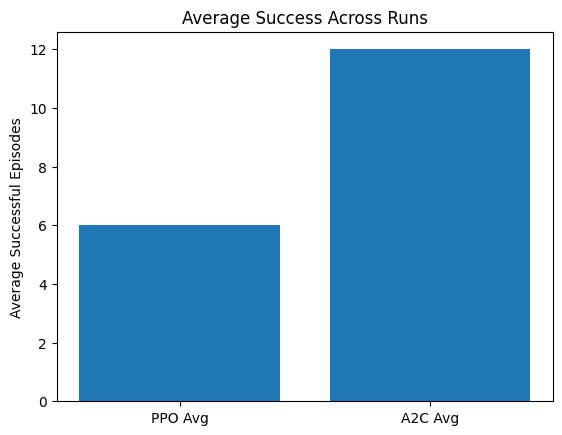

In [30]:
means = [np.mean(ppo_runs), np.mean(a2c_runs)]
labels = ["PPO Avg", "A2C Avg"]

plt.figure()
plt.bar(labels, means)
plt.ylabel("Average Successful Episodes")
plt.title("Average Success Across Runs")
plt.show()
